In [1]:
import sys
sys.path.append("/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages")
import pygame
import moviepy
import gymnasium as gym
import numpy as np
import seaborn
from tqdm import tqdm #progress bar


pygame 2.5.2 (SDL 2.28.3, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from collections import defaultdict
import matplotlib.pyplot as plt #drawing plots
from matplotlib.patches import Patch #draw shapes
from IPython.display import clear_output

In [3]:
env=gym.make("Taxi-v3",render_mode="rgb_array")

In [4]:
done=False
observation, info=env.reset()

In [5]:
action =env.action_space.sample()
observation,reward,terminated,truncated,info =env.step(action)

In [6]:
class TaxiAgent:
    def __init__(self, learning_rate:float,initial_epsilon:float,epsilon_decay:float,final_epsilon:float,discount_factor:float = 0.95):
        #Initialize RL agent with empty dictionary of state-action values, learning rate, epsilon.
        #discount_factor: the discount factor for computing the Q-value.
        self.q_values= defaultdict(lambda:np.zeros(env.action_space.n))
        self.lr=learning_rate
        self.discount_factor=discount_factor
        self.epsilon=initial_epsilon
        self.epsilon_decay=epsilon_decay
        self.final_epsilon=final_epsilon
        self.training_error=[]
    def get_action(self, obs)->int:
        if np.random.random()<self.epsilon:
            return env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[obs]))
    def update(self, obs:int, action:int, reward:float, termianted:bool, next_obs:int)->int:
        future_q_value=0
        if not terminated:
            future_q_value=np.max(self.q_values[next_obs])
        temporal_difference= (reward+self.discount_factor*future_q_value-self.q_values[obs][action])
        self.q_values[obs][action]=self.q_values[obs][action]+self.lr*temporal_difference
        self.training_error.append(temporal_difference)
    def decay_epsilon(self):
        self.epsilon=max(self.final_epsilon, self.epsilon-self.epsilon_decay)


In [7]:
learning_rate=0.01
n_episodes=10000
start_epsilon=1.0
epsilon_decay= start_epsilon/(n_episodes/2)
final_epsilon=0.1

In [8]:
agent = TaxiAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon
)

In [9]:
env=gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
env= gym.wrappers.RecordVideo(env, video_folder="taxi_agent", episode_trigger=lambda x: x%1000==0)



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


  0%|          | 0/10000 [00:00<?, ?it/s]

Moviepy - Building video /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-10000.mp4.
Moviepy - Writing video /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-10000.mp4



  0%|          | 1/10000 [00:00<39:12,  4.25it/s]

Moviepy - Done !
Moviepy - video ready /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-10000.mp4


  9%|▉         | 919/10000 [00:00<00:05, 1672.94it/s]

Moviepy - Building video /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-11000.mp4.
Moviepy - Writing video /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-11000.mp4



 11%|█         | 1100/10000 [00:01<00:07, 1124.83it/s]

Moviepy - Done !
Moviepy - video ready /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-11000.mp4


 19%|█▉        | 1908/10000 [00:01<00:04, 1783.90it/s]

Moviepy - Building video /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-12000.mp4.
Moviepy - Writing video /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-12000.mp4



 21%|██        | 2103/10000 [00:01<00:06, 1295.19it/s]

Moviepy - Done !
Moviepy - video ready /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-12000.mp4


 29%|██▉       | 2939/10000 [00:02<00:03, 1895.06it/s]

Moviepy - Building video /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-13000.mp4.
Moviepy - Writing video /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-13000.mp4



 31%|███▏      | 3144/10000 [00:02<00:05, 1251.74it/s]

Moviepy - Done !
Moviepy - video ready /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-13000.mp4


 40%|███▉      | 3987/10000 [00:02<00:03, 1863.10it/s]

Moviepy - Building video /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-14000.mp4.
Moviepy - Writing video /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-14000.mp4



 40%|███▉      | 3987/10000 [00:03<00:03, 1863.10it/s]

Moviepy - Done !
Moviepy - video ready /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-14000.mp4


 49%|████▉     | 4900/10000 [00:03<00:02, 1777.27it/s]

Moviepy - Building video /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-15000.mp4.
Moviepy - Writing video /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-15000.mp4



 51%|█████     | 5114/10000 [00:03<00:03, 1316.34it/s]

Moviepy - Done !
Moviepy - video ready /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-15000.mp4


 58%|█████▊    | 5789/10000 [00:04<00:02, 1846.42it/s]

Moviepy - Building video /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-16000.mp4.
Moviepy - Writing video /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-16000.mp4



 60%|██████    | 6002/10000 [00:04<00:03, 1252.14it/s]

Moviepy - Done !
Moviepy - video ready /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-16000.mp4


 69%|██████▉   | 6926/10000 [00:04<00:01, 1992.34it/s]

Moviepy - Building video /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-17000.mp4.
Moviepy - Writing video /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-17000.mp4



 72%|███████▏  | 7150/10000 [00:04<00:02, 1381.82it/s]

Moviepy - Done !
Moviepy - video ready /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-17000.mp4


 79%|███████▉  | 7884/10000 [00:05<00:01, 1966.71it/s]

Moviepy - Building video /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-18000.mp4.
Moviepy - Writing video /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-18000.mp4



 81%|████████  | 8109/10000 [00:05<00:01, 1396.82it/s]

Moviepy - Done !
Moviepy - video ready /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-18000.mp4


 88%|████████▊ | 8789/10000 [00:06<00:00, 1883.46it/s]

Moviepy - Building video /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-19000.mp4.
Moviepy - Writing video /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-19000.mp4



 92%|█████████▏| 9212/10000 [00:06<00:00, 1567.83it/s]

Moviepy - Done !
Moviepy - video ready /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-19000.mp4


100%|██████████| 10000/10000 [00:06<00:00, 1527.77it/s]


Moviepy - Building video /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-20000.mp4.
Moviepy - Writing video /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-20000.mp4



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.return_queue to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.return_queue` for environment variables or `env.get_wrapper_attr('return_queue')` that will search the reminding wrappers.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.length_queue to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.length_queue` for environment variables or `env.get_wrapper_attr('length_queue')` that will search the reminding wrappers.
  logger.warn(


Moviepy - Done !
Moviepy - video ready /Users/lukehoward/Documents/GitHub/Reinforcement-Learning/Taxi/taxi_agent/rl-video-episode-20000.mp4


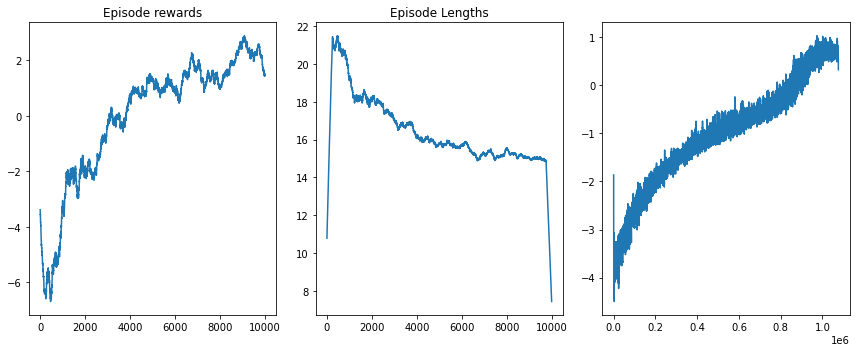

In [11]:
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    while not done:
        action = int(agent.get_action(obs))
        next_obs, reward, terminated, truncated, infos = env.step(action)

        agent.update(obs, action, reward, terminated, next_obs)

        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()
env.close()

rolling_length=500
fig, axs= plt.subplots(ncols=3, figsize=(12,5))
axs[0].set_title("Episode rewards")
reward_moving_average=(np.convolve(np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="same")/rolling_length)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode Lengths")
length_moving_average=(np.convolve(np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same")/rolling_length)
axs[1].plot(range(len(length_moving_average)),length_moving_average)
training_error_moving_average=(np.convolve(np.array(agent.training_error).flatten(), np.ones(rolling_length), mode="same")/rolling_length)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
axs[2].set_title("Episode Error")
plt.tight_layout()
plt.show()